# OBJECT DETECTION SSD MODEL

In [1]:
import d2l 
from mxnet import *
from mxnet.gluon import nn
npx.set_np()
import os

In [5]:
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                    padding= 1)

## BOUNDING BOX PREDICTION LAYER

In [6]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

## CONCATENATING PREDICTIONS FOR MULTIPLE SCALES

In [7]:
def forward(x, block):
    block.initialize()
    return block(x)

In [8]:
Y1 = forward(np.zeros((2,8,20,20)), cls_predictor(5,10))
Y2 = forward(np.zeros((2,16,10,10)), cls_predictor(3,10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

In [10]:
def flatten_pred(pred):
    return npx.batch_flatten(pred.transpose(0,2,3,1))

def concat_preds(preds):
    return np.concatenate([flatten_pred(p) for p in preds], axis= 1)

In [11]:
concat_preds([Y1, Y2]).shape

(2, 25300)

## HEIGHT AND WIDTH DOWNSAMPLE BLOCK

In [12]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
               nn.BatchNorm(in_channels= num_channels),
               nn.Activation('relu'))
        blk.add(nn.MaxPool2D(2))
        return blk

In [13]:
forward(np.zeros((2,3,20,20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

## BASE NETWORK BLOCK

In [14]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16,32,64]:
        blk.add(down_sample_blk(num_filters))
    return blk

In [15]:
forward(np.zeros((2,3,256,256)), base_net()).shape

(2, 64, 32, 32)

## THE COMPLETE MODEL

In [32]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

In [33]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = npx.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [34]:
sizes= [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
       [0.99, 0.961]]
ratios = [[1,2,0.5]] * 5
num_anchors =len(sizes[0]) + len(ratios[0]) - 1

In [39]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)

        self.num_classes = num_classes

        for i in range(5):
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, cls_predictor(num_anchors, num_classes))
            setattr(self, 'bbox_%d' % i, bbox_predictor(num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i]= blk_forward(X, getattr(self, 'blk_%d' % i), 
                                                                   sizes[i], ratios[i],
                                                                   getattr(self, 'cls_%d' % i), 
                                                                   getattr(self, 'bbox_%d' % i))
        anchors = np.concatenate(anchors, axis= 1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes+1)
        bbox_preds = concat_preds(bbox_preds)
        
        return anchors, cls_preds, bbox_preds

In [40]:
net = TinySSD(num_classes=1)
net.initialize()
X = np.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print("output anchor", anchors.shape)
print("output class preds", cls_preds.shape)
print("output bbox preds", bbox_preds.shape)

output anchor (1, 5444, 4)
output class preds (32, 5444, 2)
output bbox preds (32, 21776)


## TRAINING

In [41]:
batch_size = 32
train_iter, _ = d2l.load_data_pikachu(batch_size)

In [43]:
ctx, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init= init.Xavier(), ctx= ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                       {'learning_rate': 0.2, 'wd': 5e-4})

In [45]:
cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
bbox_loss = gluon.loss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    
    return cls + bbox

In [46]:
def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(axis=-1) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((np.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

cls err 3.08e-03, bbox mae 3.54e-03
 215.6 examples/sec on cpu(0)


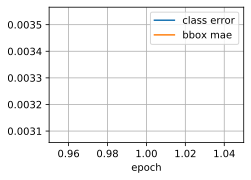

In [50]:
num_epochs, timer = 1, d2l.Timer()
animator = d2l.Animator(xlabel = 'epoch', xlim=[1, num_epochs],
                       legend=['class error', 'bbox mae'])

for epoch in range(num_epochs):
    
    metric= d2l.Accumulator(4)
    train_iter.reset()
    
    for batch in train_iter:
        timer.start()
        X = batch.data[0].as_in_ctx(ctx)
        Y = batch.label[0].as_in_ctx(ctx)
        
        with autograd.record():
            anchors, cls_preds, bbox_preds = net(X)
            bbox_labels, bbox_masks, cls_labels = npx.multibox_target(
            anchors, Y, cls_preds.transpose(0,2,1))
            
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.backward()
        trainer.step(batch_size)
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.size,
                  bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                  bbox_labels.size)
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch+1, (cls_err, bbox_mae))
    
print('cls err %.2e, bbox mae %.2e' % (cls_err, bbox_mae))
print(' %.1f examples/sec on %s' % (train_iter.num_image / timer.stop(), ctx))

## PREDICTION

In [54]:
img = image.imread('indir.png')
feature = image.imresize(img, 256, 256).astype('float32')
X = np.expand_dims(feature.transpose(2,0,1), axis=0)

In [55]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_ctx(ctx))
    cls_probs = npx.softmax(cls_preds).transpose(0,2,1)
    output = npx.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

In [57]:
def display(img, output, threshold):
    d2l.set_figsize((5,5))
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = float(row[1])
        
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * np.array((w, h, w, h), ctx= row.ctx)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

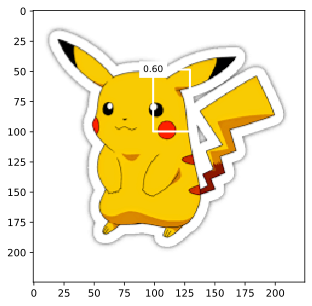

In [58]:
display(img, output, threshold=0.3)